In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [33]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak
    # 创建peak列，默认值为NaN
    '''
    
    df['peak'] = np.nan
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak'] = 'high'
            continue  # 找到高点后继续下一个点
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak'] = 'low'
    
    return df

In [3]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点
    """
    # 创建platform列，默认值为NaN
    df['platform'] = np.nan
    df['platform_length'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peak_col = df.columns.get_loc('peak')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            peak_val = df.iloc[j, peak_col]
            
            if peak_val == 'high':
                current_high_low = df.iloc[j, low_col]
            elif peak_val == 'low':
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                # 注意：iloc切片是左闭右开，所以i+1才能包含i行
                platform_high = df.iloc[j:i, high_col].max()
                df.iloc[i, df.columns.get_loc('platform')] = platform_high
                break  # 找到平台后跳出内层循环
    
    return df

In [26]:
def run(df, start_date, end_date):
    """
    回测函数
    输入：DataFrame 对应一支股票，index是日期，columns包含 high, low, open, close, platform, uplimit
    输出：(DataFrame, int) 分别为符合条件的交易日平均高开低收数据、符合条件的交易日数量
    """
    # 筛选符合条件的交易日
    valid_days = df[
        (df['high'] > df['platform']) & 
        (df['uplimit'] != df['close']) &
        (df.index >= start_date) & 
        (df.index <= end_date)
    ]
    
    # 初始化结果容器
    result = pd.DataFrame(
        0.0, 
        columns=['high', 'low', 'open', 'close'],
        index=pd.Index(range(6))
    )
    
    count = 0  # 有效交易日计数器
    
    # 遍历每个符合条件的交易日
    for idx in valid_days.index:
        # 获取当前交易日的位置
        try:
            t = df.index.get_loc(idx)
        except KeyError:
            continue  # 处理可能的索引不匹配情况
        
        # 检查是否有足够的后续数据（避免越界）
        if t + 6 > len(df):
            continue
            
        # 获取窗口数据并检查缺失值
        window = df.iloc[t:t+6][['high', 'low', 'open', 'close']]
        if window.isna().any().any():
            continue
            
        # 获取归一化基准（起始日开盘价）
        base_price = df.loc[idx, 'open']
        if pd.isna(base_price) or base_price == 0:
            continue
            
        # 归一化并累加
        result += window.div(base_price).reset_index(drop=True)
        count += 1
    
    return result, count

In [5]:
def depict_Kline(df):
    '''
    ##绘制k线图
    ##输入：DataFrame  index是日期（0-5） column是高开低收
    ##输出：画出每一天的k线图
    '''
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 计算K线实体高度和影线长度
    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # 设置涨跌颜色（红色表示上涨，绿色表示下跌）
    colors = ['red' if close >= open else 'green' for close, open in zip(df['close'], df['open'])]
    
    # 绘制K线
    for i, (index, row) in enumerate(df.iterrows()):
        # 使用索引作为X坐标
        x_pos = index
        
        # 绘制实体
        ax.bar(
            x_pos, row['body'], 
            bottom=min(row['open'], row['close']), 
            width=0.6, color=colors[i], alpha=0.8
        )
        
        # 绘制上影线和下影线
        ax.plot([x_pos, x_pos], 
                [row['high'], max(row['open'], row['close'])], 
                color='black', linewidth=1)
        ax.plot([x_pos, x_pos], 
                [min(row['open'], row['close']), row['low']], 
                color='black', linewidth=1)
    
    # 设置X轴刻度为索引值
    ax.set_xticks(df.index)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 设置标题和标签
    ax.set_title('K线图', fontsize=16)
    ax.set_xlabel('交易日', fontsize=12)
    ax.set_ylabel('价格', fontsize=12)
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='上涨'),
        Patch(facecolor='green', edgecolor='black', label='下跌')
    ]
    ax.legend(handles = legend_elements, loc='upper left')
    
    # 调整布局
    plt.tight_layout()
    
    return fig, ax

In [15]:
def stock_process(stock_id):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：单只股票用于画Kline的DataFrame
    df = shared_table[shared_table['stock_id'] == stock_id]
    stock_data = df.pivot(index='time',
                        columns='indicator',
                        values='value')
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data = climax_find(stock_data)
    stock_data = platform_find(stock_data)
    depiction_data,num = run(stock_data,'2020-01-02','2025-05-30')
    return (depiction_data,num)

In [9]:
def process_indicator(data, indicator_name):
        # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
        long_df = data.stack().reset_index()
        # 重命名列：股票ID、时间、指标值
        long_df.columns = ['stock_id', 'time', 'value']
        # 添加指标类型列（如'post'、'high'）
        long_df['indicator'] = indicator_name
        return long_df

In [10]:
###预处理 拼成长表
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
uplimit_data = ff.read('up_limit') * post_data * ff.filter0
   
df_post = process_indicator(post_data, 'post')
df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_uplimit = process_indicator(uplimit_data, 'uplimit')

long_table = pd.concat(
    [df_post, df_high, df_low, df_close, df_open, df_uplimit],
    ignore_index=True
)
    
##并行处理所有股票数据
stock_list = long_table['stock_id'].unique()    

In [29]:
def init_worker(table):
    global shared_table
    shared_table = table
    
init_worker(long_table)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5106/5106 [06:28<00:00, 13.15it/s]


(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot:title={'center':'K线图'}, xlabel='交易日', ylabel='价格'>)

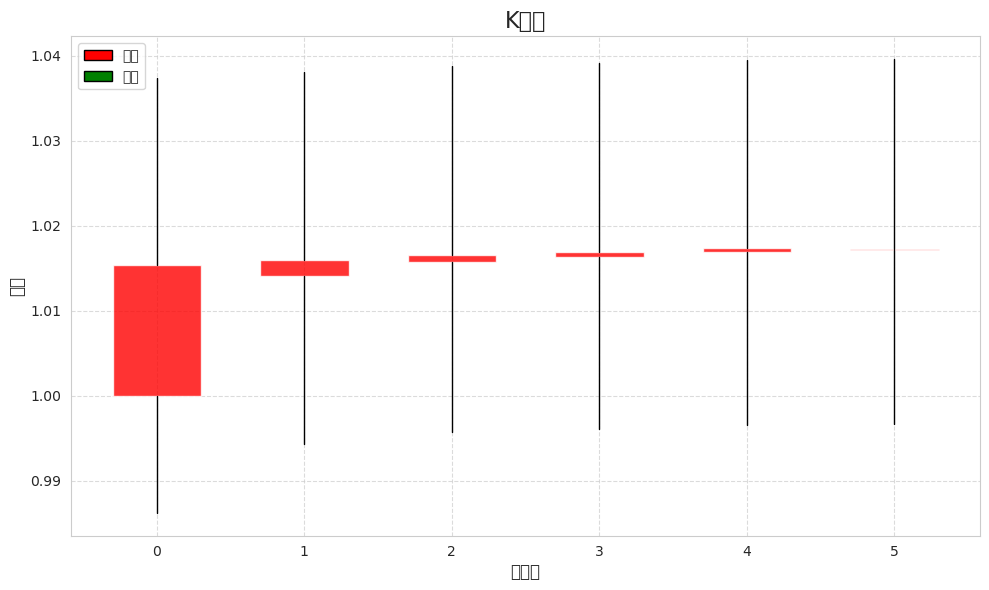

In [31]:
'''
Task1:记突破平台的时间是0，记录6天内的平均收益 绘制K线图
'''

with Pool(96, initializer=init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total=len(stock_list)))
dfs = [item[0] for item in res_lst]
nums = [item[1] for item in res_lst]
result = sum(dfs) / sum(nums)
    
depict_Kline(result)